<a href="https://colab.research.google.com/github/RylieWeaver/NLP/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8.4 Lab Assignment #4: Text Classification

https://colab.research.google.com/drive/10A0qe_HYLMwry7fOf5pgSgopu38ou6rB?usp=sharing

## Setup

### Mount Drive

In [2]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [3]:
# Travel to Lab2 Directory
%cd "/content/drive/MyDrive/CGU/NLP"

/content/drive/MyDrive/CGU/NLP


In [4]:
%ls

Lab1/  Lab2/  Lab3/  Lab3.2/  Lab3.2_extra/  Lab3_extra/  Lab4/


### Pip

In [5]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00


### Imports

In [6]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt

In [194]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [20]:
from joblib import dump
import ast

## HPO Algorithms
*   I'm providing extra content here partially in the hopes of some extra credit. Here, I allow the type of hyperparameter exploration technique as a function parameter and explore accoridng to that passed value. I implement gridsearch, random search, and optuna in a unified framework.



### Unified Framework

In [45]:
def create_objective(model_class, fixed_params, param_space, X_train, y_train, scoring='accuracy'):
    def objective(trial):
        # Dynamically construct parameters based on their types
        hpo_params = {}
        for param_name, info in param_space.items():
            if info['type'] == 'categorical':
                hpo_params[param_name] = trial.suggest_categorical(param_name, info['args'])
            elif info['type'] == 'loguniform':
                hpo_params[param_name] = trial.suggest_loguniform(param_name, *info['args'])
            elif info['type'] == 'uniform':
                hpo_params[param_name] = trial.suggest_uniform(param_name, *info['args'])
            elif info['type'] == 'int':
                hpo_params[param_name] = trial.suggest_int(param_name, *info['args'])

        model = model_class(**fixed_params, **hpo_params)
        score = np.mean(cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy'))
        return score
    return objective


def optimize_hyperparameters(model_class, fixed_params, param_space, X_train, y_train, X_test, y_test, optimization_strategy, scoring='accuracy', **hpo_kwargs):
    """
    A general function to optimize hyperparameters for a given model using different strategies.

    Parameters:
    - model_class: The machine learning model class to be optimized.
    - fixed_params: The required/constant hyperparameters of the model that we aren't optimizing
    - param_space: The hyperparameter space to search.
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Testing data and labels.
    - optimization_strategy: The strategy for optimization ('grid_search', 'randomized_search', or 'optuna').
    - scoring = What to optimize in the HPO
    - **hpo_kwargs: Additional keyword arguments for the optimization process (e.g., n_iter for RandomizedSearchCV).

    Returns:
    - best_model: The model fitted with the best hyperparameters.
    - performance: A dictionary containing performance metrics of the best model on the test set.
    """
    best_model = None
    if optimization_strategy == 'grid_search':
        model = model_class(**fixed_params)
        search = GridSearchCV(model, param_space, scoring=scoring, **hpo_kwargs)
        search.fit(X_train, y_train)
        best_params = search.best_params_
        best_model = search.best_estimator_
    elif optimization_strategy == 'randomized_search':
        model = model_class(**fixed_params)
        search = RandomizedSearchCV(model, param_space, scoring=scoring, **hpo_kwargs)
        search.fit(X_train, y_train)
        best_params = search.best_params_
        best_model = search.best_estimator_
    elif optimization_strategy == 'optuna':
        objective = create_objective(model_class, fixed_params, param_space, X_train, y_train, scoring=scoring)
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=hpo_kwargs.get('n_trials', 100))
        best_params = study.best_params
        best_model = model_class(**fixed_params, **best_params)
        best_model.fit(X_train, y_train)
    else:
        raise ValueError("Unsupported optimization strategy.")

    predictions = best_model.predict(X_test)
    performance = {
        'accuracy': accuracy_score(y_test, predictions),
        'precision': precision_score(y_test, predictions),
        'recall': recall_score(y_test, predictions),
        'f1-score': f1_score(y_test, predictions)
    }

    return best_model, best_params, performance

### Showcase

In [ ]:
# Example optuna parameter space
param_space = {
    'C': {'type': 'loguniform', 'args': [1e-3, 1e3]},  # Continuous parameter, suitable for suggest_loguniform
    'kernel': {'type': 'categorical', 'args': ['linear', 'poly', 'rbf', 'sigmoid']},  # Categorical parameter
    'gamma': {'type': 'loguniform', 'args': [1e-4, 1e-1]},  # Continuous parameter
    'degree': {'type': 'int', 'args': [1, 5]}  # Integer parameter
}


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Hyperparameter space and fixed parameters
param_space = {
    'C': np.logspace(-4, 1, 10),  # 10 values from 10^-4 to 10^1
    'solver': ['liblinear', 'lbfgs']  # Categorical parameter
}
fixed_params = {
    'max_iter': 10000  # Fixed parameter
}

# Adjust the call to match the function signature
best_model, performance = optimize_hyperparameters(
    model_class=LogisticRegression,  # Pass the class, not an instance (could be worth changing in production code).
    fixed_params=fixed_params,
    param_space=param_space,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    optimization_strategy='grid_search',
    scoring='accuracy',  # Scoring metric
    cv=5  # Number of cross-validation folds
)

print("Best Model:", best_model)
print("Optimized Model Performance:", performance)

Best Model: LogisticRegression(C=10.0, max_iter=10000)
Optimized Model Performance: {'accuracy': 0.956140350877193, 'precision': 0.9459459459459459, 'recall': 0.9859154929577465, 'f1-score': 0.9655172413793103}


In [ ]:
# For Optuna, redefine the hyperparameter space with types and ranges
param_space = {
    'C': {'type': 'loguniform', 'args': [1e-4, 10.0]},  # Loguniform distribution for 'C'
    'solver': {'type': 'categorical', 'args': ['liblinear', 'lbfgs']}  # Categorical for 'solver'
}

# Call the function with Optuna as the optimization strategy
best_model, performance = optimize_hyperparameters(
    model_class=LogisticRegression,  # Model class
    fixed_params=fixed_params,  # Fixed parameters
    param_space=param_space,  # Hyperparameter space tailored for Optuna
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    optimization_strategy='optuna',  # Use Optuna for optimization
    scoring='accuracy',  # Scoring metric
    cv=5,  # Cross-validation folds
    n_trials=20  # Correct place for n_trials
)

print("Best Model:", best_model)
print("Optimized Model Performance:", performance)

[I 2024-04-01 03:22:15,111] A new study created in memory with name: no-name-6cb1476b-ec95-4638-8cf7-5c1f574682f5
<ipython-input-29-295eeb75f192>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  hpo_params[param_name] = trial.suggest_loguniform(param_name, *info['args'])
[I 2024-04-01 03:22:16,438] Trial 0 finished with value: 0.9142857142857144 and parameters: {'C': 0.00010014388536340219, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9142857142857144.
<ipython-input-29-295eeb75f192>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  hpo_params[param_name] = trial.suggest_loguniform(param_name, *info['args'])
[I 2024-04-01 03:22:16,498] Trial 1 finished with value: 0

Best Model: LogisticRegression(C=9.515872090318137, max_iter=10000, solver='liblinear')
Optimized Model Performance: {'accuracy': 0.956140350877193, 'precision': 0.9459459459459459, 'recall': 0.9859154929577465, 'f1-score': 0.9655172413793103}


## Section 1 (BOW)

### Read File

In [32]:
%ls Lab2/

cleaned_restaurant_review_stems.csv  NLP_Lab_2.pdf               restaurant_reviews_NER.csv
Extra/                               restaurant_reviews_BOW.csv  Restaurant_reviews_R.csv


In [33]:
reviews_BOW = pd.read_csv('Lab2/restaurant_reviews_BOW.csv')

In [34]:
reviews_BOW.head()

,Restaurant,City,State,Zipcode,Business_rating_score,food,good,place,get,order,...,overall,actually,let,line,free,busy,old,steak,half,plate
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,29,31,23,24,12,...,5,5,1,0,0,5,1,0,5,3
1,21 Nickels,Watertown,MA,02472,4.0,60,64,48,51,16,...,5,5,5,2,6,4,1,11,2,1
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,13,7,38,18,50,...,0,2,1,0,1,1,0,0,1,1
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,34,39,24,19,8,...,1,1,2,0,2,0,3,0,1,1
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,15,28,38,25,18,...,1,3,3,0,0,0,1,0,3,2


In [35]:
reviews_BOW.shape

(1075, 205)

### Make Dataset

In [36]:
# Make binary target variable based off high (greater than or equal to 4) review score
reviews_BOW['business_rating'] = (reviews_BOW['Business_rating_score'] >= 4).astype(int)

In [37]:
# Clean unnecessary columns for dataset
dataset = reviews_BOW.drop(['Restaurant', 'City', 'State', 'Zipcode', 'Business_rating_score'], axis=1)

In [38]:
# Set up features and target
X = dataset.drop(['business_rating'], axis=1)
y = dataset['business_rating']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
X_train.head()

,food,good,place,get,order,go,time,like,great,come,...,overall,actually,let,line,free,busy,old,steak,half,plate
682,29,64,36,47,43,48,32,22,61,38,...,6,6,8,0,0,5,2,5,27,0
810,47,38,30,18,11,21,13,9,15,4,...,3,3,1,1,1,0,1,0,1,1
781,9,43,27,26,16,37,9,24,16,11,...,3,5,3,2,72,0,0,0,2,0
588,3,19,20,11,27,12,8,9,11,6,...,0,1,2,0,22,0,2,0,1,0
350,46,44,66,52,13,43,29,34,26,20,...,1,11,6,2,4,1,3,0,3,1


In [41]:
y_train.head()

682    1
810    0
781    1
588    1
350    0
Name: business_rating, dtype: int64

In [42]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(860, 200) (215, 200)
(860,) (215,)


### Evaluate Models w/ HPO

In [46]:
# SVM Hyperparameter Space
svm_param_space = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Gradient Boosting Hyperparameter Space
gb_param_space = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': list(range(20, 41, 2))  # From 20 to 40, step of 2
}

In [47]:
# Optimize SVM
svm_best_model, svm_best_params, svm_performance = optimize_hyperparameters(
    model_class=SVC,
    fixed_params={},  # No fixed parameters for SVM in this case
    param_space=svm_param_space,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    optimization_strategy='grid_search',
    scoring='accuracy',
    cv=5
)

In [48]:
# Optimize Gradient Boosting
gb_best_model, gb_best_params, gb_performance = optimize_hyperparameters(
    model_class=GradientBoostingClassifier,
    fixed_params={},  # No fixed parameters for Gradient Boosting in this case
    param_space=gb_param_space,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    optimization_strategy='grid_search',
    scoring='accuracy',
    cv=5
)

In [49]:
# Predictions with the best SVM model
svm_predictions = svm_best_model.predict(X_test)

# Performance metrics for SVM
print("SVM Performance:", svm_performance)
print("SVM Hyperparameters:", svm_best_params)
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

# Predictions with the best Gradient Boosting model
gb_predictions = gb_best_model.predict(X_test)

# Performance metrics for Gradient Boosting
print("Gradient Boosting Performance:", gb_performance)
print("Gradient Boosting Hyperparameters:", gb_best_params)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_predictions))

SVM Performance: {'accuracy': 0.8697674418604651, 'precision': 0.8089887640449438, 'recall': 0.8674698795180723, 'f1-score': 0.8372093023255814}
SVM Hyperparameters: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       132
           1       0.81      0.87      0.84        83

    accuracy                           0.87       215
   macro avg       0.86      0.87      0.86       215
weighted avg       0.87      0.87      0.87       215

Gradient Boosting Performance: {'accuracy': 0.8465116279069768, 'precision': 0.7840909090909091, 'recall': 0.8313253012048193, 'f1-score': 0.8070175438596491}
Gradient Boosting Hyperparameters: {'learning_rate': 1, 'max_features': 'sqrt', 'min_samples_leaf': 28, 'n_estimators': 200}
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       132
     

### Model Selection

I select the SVM model as the best performer since it has the best performance across all three statistics in the weighted average.

### Save Models

In [24]:
%ls

Lab1/  Lab2/  Lab3/  Lab3.2/  Lab3.2_extra/  Lab3_extra/  Lab4/


In [25]:
# Save SVM model
svm_model_path = "Lab4/part1_svm_best_model.joblib"
dump(svm_best_model, svm_model_path)

# Save Gradient Boosting model
gb_model_path = "Lab4/part1_gb_best_model.joblib"
dump(gb_best_model, gb_model_path)

['Lab4/part1_gb_best_model.joblib']

## Section 2 (doc2vec)

### Read File

In [50]:
%ls Lab3_extra/csv_files

business_FastText_embedding.csv  cleaned_reviews.csv     Restaurant_reviews_R.csv
business_FastText_sentiment.csv  FastText_embedding.csv  Word2Vec_embedding.csv


In [67]:
reviews_doc2vec = pd.read_csv('Lab3_extra/csv_files/business_FastText_embedding.csv')

In [72]:
reviews_doc2vec.head()

,Business,City,State,Zip,Business Rating Score,Review,FastText Embedding
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,The ambience is kind of funky & interesting. F...,"[5.077853497556027e-05, -0.0003010381067938664..."
1,21 Nickels,Watertown,MA,02472,4.0,I like 21 Nickels a ton and they'd attract mor...,"[3.8074714870288455e-05, -2.2126440006982663e-..."
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,This place needs to be shut down. I couldn't b...,"[-0.0001309090858381806, 1.8787880738576252e-0..."
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,"Well, it's re-opened.\n\nStopped in today just...","[9.591835645996795e-05, -1.3990660331078938e-0..."
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,First visit here for my weekly southern BBQ fi...,"[2.6816639600677743e-06, -4.792387378128136e-0..."


In [73]:
reviews_doc2vec.shape

(1075, 7)

### Make Dataset

**Cleaning**

In [77]:
# Make binary target variable based off high (greater than or equal to 4) review score
reviews_doc2vec['business_rating'] = (reviews_doc2vec['Business Rating Score'] >= 4).astype(int)

In [78]:
# Convert the string representations of lists to actual lists
reviews_doc2vec['FastText Embedding'] = reviews_doc2vec['FastText Embedding'].apply(ast.literal_eval)

In [86]:
print(len(reviews_doc2vec['FastText Embedding'].iloc[0]))

10200


In [89]:
# Need to average first (also requires reshaping because of odd shape of concatenated vectors)

def reshape_and_average(embedding, vector_length=300):
    if len(embedding) % vector_length != 0:
        raise ValueError("The total length of the embedding is not a multiple of the vector length.")

    # Reshape the embedding into a 2D array where each row is one vector
    reshaped_embedding = np.array(embedding).reshape(-1, vector_length)

    # Compute the mean across these vectors
    averaged_embedding = np.mean(reshaped_embedding, axis=0)

    return averaged_embedding

# Apply this function to each row in the DataFrame
reviews_doc2vec['Averaged FastText Embedding'] = reviews_doc2vec['FastText Embedding'].apply(
    lambda embedding: reshape_and_average(embedding)
)

In [90]:
reviews_doc2vec.head()

,Business,City,State,Zip,Business Rating Score,Review,FastText Embedding,business_rating,Averaged FastText Embedding
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,The ambience is kind of funky & interesting. F...,"[5.077853497556027e-05, -0.0003010381067938664...",0,"[1.2700511156710245e-05, -0.000172966722218532..."
1,21 Nickels,Watertown,MA,02472,4.0,I like 21 Nickels a ton and they'd attract mor...,"[3.8074714870288455e-05, -2.2126440006982663e-...",1,"[-4.417423312451308e-05, -4.206033745276996e-0..."
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,This place needs to be shut down. I couldn't b...,"[-0.0001309090858381806, 1.8787880738576252e-0...",0,"[-1.6321259390077866e-05, 8.565952167390869e-0..."
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,"Well, it's re-opened.\n\nStopped in today just...","[9.591835645996795e-05, -1.3990660331078938e-0...",0,"[-1.6374766014589134e-05, -5.6687083128567575e..."
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,First visit here for my weekly southern BBQ fi...,"[2.6816639600677743e-06, -4.792387378128136e-0...",0,"[-8.210486478620784e-05, -4.327365274885088e-0..."


In [91]:
# Convert each averaged embedding into a separate column
embeddings_df = pd.DataFrame(reviews_doc2vec['Averaged FastText Embedding'].tolist(), columns=[f'Embedding_{i}' for i in range(300)])

In [92]:
# Concatenate the new DataFrame with the original one (excluding the original 'FastText Embedding' column if desired)
reviews_doc2vec = pd.concat([reviews_doc2vec.drop(['FastText Embedding', 'Averaged FastText Embedding'], axis=1), embeddings_df], axis=1)

In [93]:
reviews_doc2vec.head()

,Business,City,State,Zip,Business Rating Score,Review,business_rating,Embedding_0,Embedding_1,Embedding_2,...,Embedding_290,Embedding_291,Embedding_292,Embedding_293,Embedding_294,Embedding_295,Embedding_296,Embedding_297,Embedding_298,Embedding_299
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,The ambience is kind of funky & interesting. F...,0,0.000013,-0.000173,0.000161,...,-0.000045,0.000178,-0.000076,0.000023,0.000096,-0.000183,0.000070,-0.000010,-0.000160,-0.000067
1,21 Nickels,Watertown,MA,02472,4.0,I like 21 Nickels a ton and they'd attract mor...,1,-0.000044,-0.000042,0.000117,...,-0.000004,0.000121,-0.000071,-0.000018,0.000057,-0.000126,0.000031,0.000022,-0.000098,-0.000033
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,This place needs to be shut down. I couldn't b...,0,-0.000016,0.000009,0.000092,...,0.000021,0.000095,-0.000095,-0.000005,0.000126,-0.000278,0.000034,-0.000024,-0.000231,-0.000088
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,"Well, it's re-opened.\n\nStopped in today just...",0,-0.000016,-0.000057,0.000146,...,0.000004,0.000133,-0.000037,-0.000034,0.000064,-0.000144,0.000029,0.000010,-0.000102,-0.000035
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,First visit here for my weekly southern BBQ fi...,0,-0.000082,-0.000043,0.000151,...,0.000010,0.000141,-0.000132,-0.000012,0.000147,-0.000200,0.000073,0.000017,-0.000188,-0.000067


In [94]:
reviews_doc2vec.shape

(1075, 307)

In [104]:
# Clean unnecessary columns for dataset
dataset = reviews_doc2vec.drop(['Business', 'City', 'State', 'Zip', 'Business Rating Score', 'Review'], axis=1)

**Splitting**

In [105]:
# Set up features and target
X = dataset.drop(['business_rating'], axis=1)
y = dataset['business_rating']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [120]:
X_train.head()

,Embedding_0,Embedding_1,Embedding_2,Embedding_3,Embedding_4,Embedding_5,Embedding_6,Embedding_7,Embedding_8,Embedding_9,...,Embedding_290,Embedding_291,Embedding_292,Embedding_293,Embedding_294,Embedding_295,Embedding_296,Embedding_297,Embedding_298,Embedding_299
682,-0.000014,-0.000043,0.000050,-1.481924e-06,-0.000016,-0.000063,-0.000020,-0.000666,-0.000036,0.000041,...,-0.000021,0.000076,-0.000020,-0.000029,0.000035,-0.000086,0.000030,0.000028,-0.000052,-0.000028
810,-0.000037,-0.000117,0.000134,-9.257087e-06,-0.000037,-0.000156,-0.000088,-0.001620,-0.000072,0.000048,...,-0.000075,0.000157,-0.000080,-0.000015,0.000093,-0.000135,0.000039,0.000018,-0.000182,-0.000022
781,0.000015,-0.000027,0.000060,-3.598355e-07,-0.000044,-0.000078,-0.000007,-0.000899,-0.000073,-0.000021,...,-0.000072,0.000071,-0.000042,-0.000036,0.000055,-0.000136,0.000074,-0.000003,-0.000117,-0.000003
588,0.000008,-0.000018,0.000087,2.306830e-05,-0.000068,-0.000155,-0.000080,-0.001525,-0.000057,0.000027,...,-0.000104,0.000067,0.000006,-0.000082,0.000140,-0.000252,0.000059,0.000003,-0.000150,-0.000104
350,-0.000015,-0.000037,0.000066,2.512695e-05,-0.000009,-0.000083,-0.000025,-0.000934,-0.000046,0.000001,...,-0.000016,0.000072,-0.000051,-0.000034,0.000051,-0.000119,0.000026,-0.000012,-0.000081,-0.000032


In [121]:
y_train.head()

682    1
810    0
781    1
588    1
350    0
Name: business_rating, dtype: int64

In [122]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(860, 300) (215, 300)
(860,) (215,)


### Feature reduction

I create the PCA projection with SVD based on the train set and apply to the test set so as to avoid using information from the test set

Number of components: 0 | Variance explained: 100.00%
Number of components: 1 | Variance explained: 95.76%


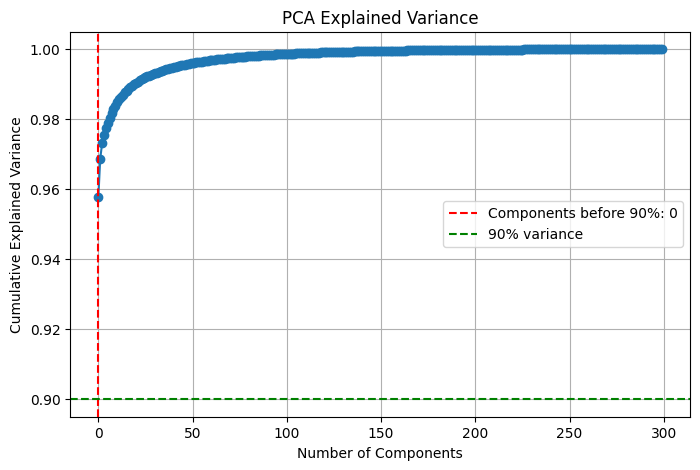

In [114]:
# Initialize PCA without specifying n_components to retain all components
# I do this instead of TruncatedSVD so I that I can more easily make this graph
pca = PCA()

# Fit PCA on the training data
pca.fit(X_train)

# Calculate the cumulative variance explained by the PCA components
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components just before reaching 90% variance
components_before_cutoff = np.argmax(cumulative_variance >= 0.9)
# Print the component and variance explained around 90% variance
print(f"Number of components: {components_before_cutoff} | Variance explained: {cumulative_variance[components_before_cutoff - 1]*100:.2f}%")
print(f"Number of components: {components_before_cutoff + 1} | Variance explained: {cumulative_variance[components_before_cutoff]*100:.2f}%")

# Plot the cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axvline(x=components_before_cutoff, linestyle='--', color='r', label=f'Components before 90%: {components_before_cutoff}')
plt.axhline(y=0.9, linestyle='--', color='green', label='90% variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [115]:
# Apply PCA to the train and test set with number of components to get 90% of variance
pca_90 = PCA(n_components=components_before_cutoff + 1)

# Fit PCA on the training data
pca_90.fit(X_train)

# Transform both X_train and X_test using the fitted PCA model
X_train_svd = pca_90.transform(X_train)
X_test_svd = pca_90.transform(X_test)

In [116]:
print(X_train_svd.shape, X_test_svd.shape)

(860, 1) (215, 1)


### Evaluate Models w/ HPO (Full)

In [110]:
# SVM Hyperparameter Space
svm_param_space = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Gradient Boosting Hyperparameter Space
gb_param_space = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2']
}

**Full parameters**

In [123]:
# Optimize SVM
svm_best_model, svm_best_params, svm_performance = optimize_hyperparameters(
    model_class=SVC,
    fixed_params={},  # No fixed parameters for SVM in this case
    param_space=svm_param_space,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    optimization_strategy='grid_search',
    scoring='accuracy',
    cv=5
)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
# Optimize Gradient Boosting
gb_best_model, gb_best_params, gb_performance = optimize_hyperparameters(
    model_class=GradientBoostingClassifier,
    fixed_params={'min_samples_leaf': 28},  # Fixed parameter of min_samples_leaf from HPO in part 1
    param_space=gb_param_space,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    optimization_strategy='grid_search',
    scoring='accuracy',
    cv=5
)

**Reduced parameters (SVD w/ 0.9 variance)**

In [117]:
# Optimize SVM
svm_reduced_best_model, svm_reduced_best_params, svm_reduced_performance = optimize_hyperparameters(
    model_class=SVC,
    fixed_params={},  # No fixed parameters for SVM in this case
    param_space=svm_param_space,
    X_train=X_train_svd,
    y_train=y_train,
    X_test=X_test_svd,
    y_test=y_test,
    optimization_strategy='grid_search',
    scoring='accuracy',
    cv=5
)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
# Optimize Gradient Boosting
gb_reduced_best_model, gb_reduced_best_params, gb_reduced_performance = optimize_hyperparameters(
    model_class=GradientBoostingClassifier,
    fixed_params={'min_samples_leaf': 28},  # Fixed parameter of min_samples_leaf from HPO in part 1
    param_space=gb_param_space,
    X_train=X_train_svd,
    y_train=y_train,
    X_test=X_test_svd,
    y_test=y_test,
    optimization_strategy='grid_search',
    scoring='accuracy',
    cv=5
)

In [125]:
# Printing performance and hyperparameters for all models
models = {
    "SVM Original": (svm_best_model, svm_performance, svm_best_params),
    "Gradient Boosting Original": (gb_best_model, gb_performance, gb_best_params),
    "SVM Reduced": (svm_reduced_best_model, svm_reduced_best_params, svm_reduced_performance),
    "Gradient Boosting Reduced": (gb_reduced_best_model, gb_reduced_best_params, gb_reduced_performance)
}

for name, (model, performance, params) in models.items():
    predictions = model.predict(X_test_svd if "Reduced" in name else X_test)
    print(f"{name} Performance:", performance)
    print(f"{name} Best Hyperparameters:", params)
    print(f"{name} Classification Report:")
    print(classification_report(y_test, predictions))
    print("-" * 80)

SVM Original Performance: {'accuracy': 0.6139534883720931, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}
SVM Original Best Hyperparameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
SVM Original Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       132
           1       0.00      0.00      0.00        83

    accuracy                           0.61       215
   macro avg       0.31      0.50      0.38       215
weighted avg       0.38      0.61      0.47       215

--------------------------------------------------------------------------------
Gradient Boosting Original Performance: {'accuracy': 0.8697674418604651, 'precision': 0.8481012658227848, 'recall': 0.8072289156626506, 'f1-score': 0.8271604938271606}
Gradient Boosting Original Best Hyperparameters: {'learning_rate': 1, 'max_features': 'log2', 'n_estimators': 200}
Gradient Boosting Original Classification Report:
              precision    recall  f1-s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### Model Selection

I select the Gradient Boosted model with full feature set as the best performer since it has the best performance across all three statistics in the weighted average.

### Save Models

In [126]:
%ls

Lab1/  Lab2/  Lab3/  Lab3.2/  Lab3.2_extra/  Lab3_extra/  Lab4/


In [127]:
# Save SVM models
svm_model_path = "Lab4/part2_svm_best_model.joblib"
dump(svm_best_model, svm_model_path)
svm_reduced_model_path = "Lab4/part2_svm_reduced_best_model.joblib"
dump(svm_reduced_best_model, svm_reduced_model_path)

# Save Gradient Boosting models
gb_model_path = "Lab4/part2_gb_best_model.joblib"
dump(gb_best_model, gb_model_path)
gb_reduced_model_path = "Lab4/part2_gb_reduced_best_model.joblib"
dump(gb_reduced_best_model, gb_reduced_model_path)

['Lab4/part2_gb_best_model.joblib']

## Section 3 (NER)

### Read Files

**NER Tags**

In [128]:
%ls Lab2/

cleaned_restaurant_review_stems.csv  NLP_Lab_2.pdf               restaurant_reviews_NER.csv
Extra/                               restaurant_reviews_BOW.csv  Restaurant_reviews_R.csv


In [173]:
reviews_NER = pd.read_csv('Lab2/restaurant_reviews_NER.csv')

In [174]:
reviews_NER.head()

,Restaurant,City,State,Zipcode,Business_rating_score,Reviews,ner_counts
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,The ambience is kind of funky & interesting. F...,"{'ORG': 30, 'PERSON': 37, 'DATE': 13}"
1,21 Nickels,Watertown,MA,02472,4.0,I like 21 Nickels a ton and they'd attract mor...,"{'ORG': 57, 'PERSON': 34, 'DATE': 36}"
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,This place needs to be shut down. I couldn't b...,"{'ORG': 16, 'PERSON': 5, 'DATE': 4}"
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,"Well, it's re-opened.\n\nStopped in today just...","{'ORG': 27, 'PERSON': 27, 'DATE': 37}"
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,First visit here for my weekly southern BBQ fi...,"{'ORG': 39, 'PERSON': 21, 'DATE': 8}"


In [175]:
reviews_NER.shape

(1075, 7)

**Sentiment Tags**

In [147]:
%ls Lab3_extra/csv_files/

business_FastText_embedding.csv  cleaned_reviews.csv     Restaurant_reviews_R.csv
business_FastText_sentiment.csv  FastText_embedding.csv  Word2Vec_embedding.csv


In [168]:
reviews_sentiment = pd.read_csv('Lab3_extra/csv_files/business_FastText_sentiment.csv')
reviews_sentiment.rename(columns={'Business': 'Restaurant', 'Zip': 'Zipcode'}, inplace=True)  # Rename column to later merge

In [169]:
reviews_sentiment.head()

,Restaurant,City,State,Zipcode,Business Rating Score,Polarity,Subjectivity,NLTK_Compound
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,0.141160,0.486269,0.426003
1,21 Nickels,Watertown,MA,02472,4.0,0.243878,0.562022,0.797088
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,-0.118964,0.566542,-0.166997
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,0.205975,0.566806,0.705704
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,0.212405,0.562440,0.652147


In [170]:
reviews_sentiment.shape

(1075, 8)

### Make Dataset

In [176]:
# Assuming 'df' is your DataFrame and it has a column 'ner_counts' which contains string representations of dictionaries
reviews_NER['ner_counts'] = reviews_NER['ner_counts'].apply(ast.literal_eval)  # Convert stringified dictionaries to actual dictionaries

# Initialize columns for each NER tag with default value 0
ner_tags = set(tag for row in reviews_NER['ner_counts'] for tag in row.keys())
for tag in ner_tags:
    reviews_NER[f'{tag}'] = 0

# Populate the columns with actual counts
for index, row in reviews_NER.iterrows():
    for tag, count in row['ner_counts'].items():
        reviews_NER.at[index, f'{tag}'] = count

In [177]:
reviews_NER.head()

,Restaurant,City,State,Zipcode,Business_rating_score,Reviews,ner_counts,DATE,PERSON,ORG
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,The ambience is kind of funky & interesting. F...,"{'ORG': 30, 'PERSON': 37, 'DATE': 13}",13,37,30
1,21 Nickels,Watertown,MA,02472,4.0,I like 21 Nickels a ton and they'd attract mor...,"{'ORG': 57, 'PERSON': 34, 'DATE': 36}",36,34,57
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,This place needs to be shut down. I couldn't b...,"{'ORG': 16, 'PERSON': 5, 'DATE': 4}",4,5,16
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,"Well, it's re-opened.\n\nStopped in today just...","{'ORG': 27, 'PERSON': 27, 'DATE': 37}",37,27,27
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,First visit here for my weekly southern BBQ fi...,"{'ORG': 39, 'PERSON': 21, 'DATE': 8}",8,21,39


In [178]:
reviews_df = pd.merge(reviews_NER, reviews_sentiment, on=['Restaurant', 'City', 'State', 'Zipcode'], how='inner')

In [179]:
reviews_df.head()

,Restaurant,City,State,Zipcode,Business_rating_score,Reviews,ner_counts,DATE,PERSON,ORG,Business Rating Score,Polarity,Subjectivity,NLTK_Compound
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,The ambience is kind of funky & interesting. F...,"{'ORG': 30, 'PERSON': 37, 'DATE': 13}",13,37,30,3.0,0.141160,0.486269,0.426003
1,21 Nickels,Watertown,MA,02472,4.0,I like 21 Nickels a ton and they'd attract mor...,"{'ORG': 57, 'PERSON': 34, 'DATE': 36}",36,34,57,4.0,0.243878,0.562022,0.797088
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,This place needs to be shut down. I couldn't b...,"{'ORG': 16, 'PERSON': 5, 'DATE': 4}",4,5,16,1.0,-0.118964,0.566542,-0.166997
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,"Well, it's re-opened.\n\nStopped in today just...","{'ORG': 27, 'PERSON': 27, 'DATE': 37}",37,27,27,3.0,0.205975,0.566806,0.705704
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,First visit here for my weekly southern BBQ fi...,"{'ORG': 39, 'PERSON': 21, 'DATE': 8}",8,21,39,3.0,0.212405,0.562440,0.652147


In [180]:
# Make binary target variable based off high (greater than or equal to 4) review score
reviews_df['business_rating'] = (reviews_df['Business_rating_score'] >= 4).astype(int)

In [188]:
# Clean unnecessary columns for dataset
dataset = reviews_df.drop(['Restaurant', 'City', 'State', 'Zipcode', 'Business_rating_score', 'Reviews', 'ner_counts', 'Business Rating Score'], axis=1)
dataset = dataset.reset_index(drop=True)

In [189]:
# Set up features and target
X = dataset.drop(['business_rating'], axis=1)
y = dataset['business_rating']

In [198]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [202]:
# Make sure they're DataFrames
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [203]:
X_train.head()

,DATE,PERSON,ORG,Polarity,Subjectivity,NLTK_Compound
0,0.290258,-0.134569,1.087534,0.545139,0.096373,0.548238
1,-0.913935,-0.276117,-0.840663,0.751632,-0.267306,0.364832
2,0.715267,1.233727,-0.934722,1.376238,1.442418,1.314212
3,-1.126439,-0.983857,-1.357985,0.606855,0.185505,0.229827
4,0.502763,0.242892,1.510797,-0.159407,0.546206,-0.369565


In [204]:
y_train.head()

682    1
810    0
781    1
588    1
350    0
Name: business_rating, dtype: int64

In [205]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(860, 6) (215, 6)
(860,) (215,)


### Evaluate Models w/ HPO

In [206]:
# SVM Hyperparameter Space
svm_param_space = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Gradient Boosting Hyperparameter Space
gb_param_space = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2']
}

In [207]:
# Optimize SVM
svm_best_model, svm_best_params, svm_performance = optimize_hyperparameters(
    model_class=SVC,
    fixed_params={},  # No fixed parameters for SVM in this case
    param_space=svm_param_space,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    optimization_strategy='grid_search',
    scoring='accuracy',
    cv=5
)

In [208]:
# Optimize Gradient Boosting
gb_best_model, gb_best_params, gb_performance = optimize_hyperparameters(
    model_class=GradientBoostingClassifier,
    fixed_params={'min_samples_leaf': 28},  # Fixed parameter of min_samples_leaf from HPO in part 1
    param_space=gb_param_space,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    optimization_strategy='grid_search',
    scoring='accuracy',
    cv=5
)

In [209]:
# Predictions with the best SVM model
svm_predictions = svm_best_model.predict(X_test)

# Performance metrics for SVM
print("SVM Performance:", svm_performance)
print("SVM Hyperparameters:", svm_best_params)
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

# Predictions with the best Gradient Boosting model
gb_predictions = gb_best_model.predict(X_test)

# Performance metrics for Gradient Boosting
print("Gradient Boosting Performance:", gb_performance)
print("Gradient Boosting Hyperparameters:", gb_best_params)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_predictions))

SVM Performance: {'accuracy': 0.8651162790697674, 'precision': 0.7872340425531915, 'recall': 0.891566265060241, 'f1-score': 0.8361581920903955}
SVM Hyperparameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       132
           1       0.79      0.89      0.84        83

    accuracy                           0.87       215
   macro avg       0.86      0.87      0.86       215
weighted avg       0.87      0.87      0.87       215

Gradient Boosting Performance: {'accuracy': 0.8558139534883721, 'precision': 0.7888888888888889, 'recall': 0.8554216867469879, 'f1-score': 0.8208092485549133}
Gradient Boosting Hyperparameters: {'learning_rate': 0.01, 'max_features': 'log2', 'n_estimators': 500}
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       132
           1       0.7

### Model Selection

I select the SVM model as the best performer since it has the best performance across all three statistics in the weighted average.

### Save Models

In [210]:
%ls

Lab1/  Lab2/  Lab3/  Lab3.2/  Lab3.2_extra/  Lab3_extra/  Lab4/


In [211]:
# Save SVM model
svm_model_path = "Lab4/part3_svm_best_model.joblib"
dump(svm_best_model, svm_model_path)

# Save Gradient Boosting model
gb_model_path = "Lab4/part3_gb_best_model.joblib"
dump(gb_best_model, gb_model_path)

['Lab4/part3_gb_best_model.joblib']

## Section 4 (Hybrid)

### Read and Clean Dataframes

**word2vec**

In [284]:
%ls Lab3_extra/csv_files

business_FastText_embedding.csv  cleaned_reviews.csv     Restaurant_reviews_R.csv
business_FastText_sentiment.csv  FastText_embedding.csv  Word2Vec_embedding.csv


In [285]:
reviews_word2vec = pd.read_csv('Lab3_extra/csv_files/business_FastText_embedding.csv')

In [286]:
# Convert the string representations of lists to actual lists
reviews_word2vec['FastText Embedding'] = reviews_word2vec['FastText Embedding'].apply(ast.literal_eval)

In [287]:
# Need to average first (also requires reshaping because of odd shape of concatenated vectors)

def reshape_and_average(embedding, vector_length=300):
    if len(embedding) % vector_length != 0:
        raise ValueError("The total length of the embedding is not a multiple of the vector length.")

    # Reshape the embedding into a 2D array where each row is one vector
    reshaped_embedding = np.array(embedding).reshape(-1, vector_length)

    # Compute the mean across these vectors
    averaged_embedding = np.mean(reshaped_embedding, axis=0)

    return averaged_embedding

# Apply this function to each row in the DataFrame
reviews_word2vec['Averaged FastText Embedding'] = reviews_word2vec['FastText Embedding'].apply(
    lambda embedding: reshape_and_average(embedding)
)

In [288]:
# Convert each averaged embedding into a separate column
embeddings_df = pd.DataFrame(reviews_word2vec['Averaged FastText Embedding'].tolist(), columns=[f'Embedding_{i}' for i in range(300)])

In [289]:
# Concatenate the new DataFrame with the original one (excluding the original 'FastText Embedding' column if desired)
reviews_word2vec = pd.concat([reviews_word2vec.drop(['Review', 'FastText Embedding', 'Averaged FastText Embedding'], axis=1), embeddings_df], axis=1)

In [290]:
reviews_word2vec.head()

,Business,City,State,Zip,Business Rating Score,Embedding_0,Embedding_1,Embedding_2,Embedding_3,Embedding_4,...,Embedding_290,Embedding_291,Embedding_292,Embedding_293,Embedding_294,Embedding_295,Embedding_296,Embedding_297,Embedding_298,Embedding_299
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,0.000013,-0.000173,0.000161,0.000057,-0.000012,...,-0.000045,0.000178,-0.000076,0.000023,0.000096,-0.000183,0.000070,-0.000010,-0.000160,-0.000067
1,21 Nickels,Watertown,MA,02472,4.0,-0.000044,-0.000042,0.000117,0.000005,-0.000037,...,-0.000004,0.000121,-0.000071,-0.000018,0.000057,-0.000126,0.000031,0.000022,-0.000098,-0.000033
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,-0.000016,0.000009,0.000092,0.000037,0.000111,...,0.000021,0.000095,-0.000095,-0.000005,0.000126,-0.000278,0.000034,-0.000024,-0.000231,-0.000088
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,-0.000016,-0.000057,0.000146,0.000017,-0.000017,...,0.000004,0.000133,-0.000037,-0.000034,0.000064,-0.000144,0.000029,0.000010,-0.000102,-0.000035
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,-0.000082,-0.000043,0.000151,0.000046,-0.000057,...,0.000010,0.000141,-0.000132,-0.000012,0.000147,-0.000200,0.000073,0.000017,-0.000188,-0.000067


In [ ]:
reviews_word2vec.shape

(1075, 7)

**NER Tags**

In [291]:
%ls Lab2/

cleaned_restaurant_review_stems.csv  NLP_Lab_2.pdf               restaurant_reviews_NER.csv
Extra/                               restaurant_reviews_BOW.csv  Restaurant_reviews_R.csv


In [292]:
reviews_NER = pd.read_csv('Lab2/restaurant_reviews_NER.csv')

In [293]:
# Assuming 'df' is your DataFrame and it has a column 'ner_counts' which contains string representations of dictionaries
reviews_NER['ner_counts'] = reviews_NER['ner_counts'].apply(ast.literal_eval)  # Convert stringified dictionaries to actual dictionaries

# Initialize columns for each NER tag with default value 0
ner_tags = set(tag for row in reviews_NER['ner_counts'] for tag in row.keys())
for tag in ner_tags:
    reviews_NER[f'{tag}'] = 0

# Populate the columns with actual counts
for index, row in reviews_NER.iterrows():
    for tag, count in row['ner_counts'].items():
        reviews_NER.at[index, f'{tag}'] = count

In [294]:
reviews_NER = reviews_NER.drop(['Reviews', 'ner_counts'], axis=1)
reviews_NER.rename(columns={'Business_rating_score': 'Business Rating Score', 'Restaurant': 'Business', 'Zipcode': 'Zip'}, inplace=True)  # Rename column to later merge

In [295]:
reviews_NER.head()

,Business,City,State,Zip,Business Rating Score,DATE,PERSON,ORG
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,13,37,30
1,21 Nickels,Watertown,MA,02472,4.0,36,34,57
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,4,5,16
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,37,27,27
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,8,21,39


In [257]:
reviews_NER.shape

(1075, 7)

**Sentiment Tags**

In [296]:
%ls Lab3_extra/csv_files/

business_FastText_embedding.csv  cleaned_reviews.csv     Restaurant_reviews_R.csv
business_FastText_sentiment.csv  FastText_embedding.csv  Word2Vec_embedding.csv


In [300]:
reviews_sentiment = pd.read_csv('Lab3_extra/csv_files/business_FastText_sentiment.csv')

In [301]:
reviews_sentiment.head()

,Business,City,State,Zip,Business Rating Score,Polarity,Subjectivity,NLTK_Compound
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,0.141160,0.486269,0.426003
1,21 Nickels,Watertown,MA,02472,4.0,0.243878,0.562022,0.797088
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,-0.118964,0.566542,-0.166997
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,0.205975,0.566806,0.705704
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,0.212405,0.562440,0.652147


In [302]:
reviews_sentiment.shape

(1075, 8)

### Merge

In [331]:
reviews_df = pd.merge(reviews_NER, reviews_sentiment, on=['Business', 'City', 'State', 'Zip'], how='inner')
reviews_df = pd.merge(reviews_df, reviews_word2vec, on=['Business', 'City', 'State', 'Zip'], how='inner')

In [332]:
reviews_df.head()

,Business,City,State,Zip,Business Rating Score_x,DATE,PERSON,ORG,Business Rating Score_y,Polarity,...,Embedding_290,Embedding_291,Embedding_292,Embedding_293,Embedding_294,Embedding_295,Embedding_296,Embedding_297,Embedding_298,Embedding_299
0,1/2 Roll,Vancouver,BC,V5V 3P6,3.0,13,37,30,3.0,0.141160,...,-0.000045,0.000178,-0.000076,0.000023,0.000096,-0.000183,0.000070,-0.000010,-0.000160,-0.000067
1,21 Nickels,Watertown,MA,02472,4.0,36,34,57,4.0,0.243878,...,-0.000004,0.000121,-0.000071,-0.000018,0.000057,-0.000126,0.000031,0.000022,-0.000098,-0.000033
2,24 Hour Pizza Delivery,Boston,MA,02124,1.0,4,5,16,1.0,-0.118964,...,0.000021,0.000095,-0.000095,-0.000005,0.000126,-0.000278,0.000034,-0.000024,-0.000231,-0.000088
3,3 Monkeys Pub & Grill,Vancouver,WA,98665,3.0,37,27,27,3.0,0.205975,...,0.000004,0.000133,-0.000037,-0.000034,0.000064,-0.000144,0.000029,0.000010,-0.000102,-0.000035
4,5th St Ribs-N-Blues,Atlanta,GA,30308,3.0,8,21,39,3.0,0.212405,...,0.000010,0.000141,-0.000132,-0.000012,0.000147,-0.000200,0.000073,0.000017,-0.000188,-0.000067


In [333]:
# Make binary target variable based off high (greater than or equal to 4) review score
reviews_df['business_rating'] = (reviews_df['Business Rating Score'] >= 4).astype(int)

In [334]:
# Clean unnecessary columns for dataset
dataset = reviews_df.drop(['Business', 'City', 'State', 'Zip', 'Business Rating Score_x', 'Business Rating Score_y', 'Business Rating Score'], axis=1)
dataset = dataset.reset_index(drop=True)

### Split

In [335]:
# Set up features and target
X = dataset.drop(['business_rating'], axis=1)
y = dataset['business_rating']

In [336]:
X.head()

,DATE,PERSON,ORG,Polarity,Subjectivity,NLTK_Compound,Embedding_0,Embedding_1,Embedding_2,Embedding_3,...,Embedding_290,Embedding_291,Embedding_292,Embedding_293,Embedding_294,Embedding_295,Embedding_296,Embedding_297,Embedding_298,Embedding_299
0,13,37,30,0.141160,0.486269,0.426003,0.000013,-0.000173,0.000161,0.000057,...,-0.000045,0.000178,-0.000076,0.000023,0.000096,-0.000183,0.000070,-0.000010,-0.000160,-0.000067
1,36,34,57,0.243878,0.562022,0.797088,-0.000044,-0.000042,0.000117,0.000005,...,-0.000004,0.000121,-0.000071,-0.000018,0.000057,-0.000126,0.000031,0.000022,-0.000098,-0.000033
2,4,5,16,-0.118964,0.566542,-0.166997,-0.000016,0.000009,0.000092,0.000037,...,0.000021,0.000095,-0.000095,-0.000005,0.000126,-0.000278,0.000034,-0.000024,-0.000231,-0.000088
3,37,27,27,0.205975,0.566806,0.705704,-0.000016,-0.000057,0.000146,0.000017,...,0.000004,0.000133,-0.000037,-0.000034,0.000064,-0.000144,0.000029,0.000010,-0.000102,-0.000035
4,8,21,39,0.212405,0.562440,0.652147,-0.000082,-0.000043,0.000151,0.000046,...,0.000010,0.000141,-0.000132,-0.000012,0.000147,-0.000200,0.000073,0.000017,-0.000188,-0.000067


In [339]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [340]:
# Make sure they're DataFrames
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [341]:
X_train.head()

,DATE,PERSON,ORG,Polarity,Subjectivity,NLTK_Compound,Embedding_0,Embedding_1,Embedding_2,Embedding_3,...,Embedding_290,Embedding_291,Embedding_292,Embedding_293,Embedding_294,Embedding_295,Embedding_296,Embedding_297,Embedding_298,Embedding_299
682,29,32,58,0.248704,0.561997,0.715384,-0.000014,-0.000043,0.000050,-1.481924e-06,...,-0.000021,0.000076,-0.000020,-0.000029,0.000035,-0.000086,0.000030,0.000028,-0.000052,-0.000028
810,12,29,17,0.268129,0.551335,0.673754,-0.000037,-0.000117,0.000134,-9.257087e-06,...,-0.000075,0.000157,-0.000080,-0.000015,0.000093,-0.000135,0.000039,0.000018,-0.000182,-0.000022
781,35,61,15,0.326884,0.601459,0.889247,0.000015,-0.000027,0.000060,-3.598355e-07,...,-0.000072,0.000071,-0.000042,-0.000036,0.000055,-0.000136,0.000074,-0.000003,-0.000117,-0.000003
588,9,14,6,0.254510,0.564610,0.643110,0.000008,-0.000018,0.000087,2.306830e-05,...,-0.000104,0.000067,0.000006,-0.000082,0.000140,-0.000252,0.000059,0.000003,-0.000150,-0.000104
350,32,40,67,0.182429,0.575185,0.507058,-0.000015,-0.000037,0.000066,2.512695e-05,...,-0.000016,0.000072,-0.000051,-0.000034,0.000051,-0.000119,0.000026,-0.000012,-0.000081,-0.000032


In [312]:
y_train.head()

682    1
810    0
781    1
588    1
350    0
Name: business_rating, dtype: int64

In [342]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(860, 306) (215, 306)
(860,) (215,)


### Apply Transformations (Scale / SVD)

**SVD**

I create the PCA projection with SVD based on the train set and apply to the test set so as to avoid using information from the test set

In [359]:
columns = [col for col in X.columns if col.startswith('Embedding')]
X_train_svd = X_train[columns]
X_test_svd = X_test[columns]

Number of components: 0 | Variance explained: 100.00%
Number of components: 1 | Variance explained: 95.76%


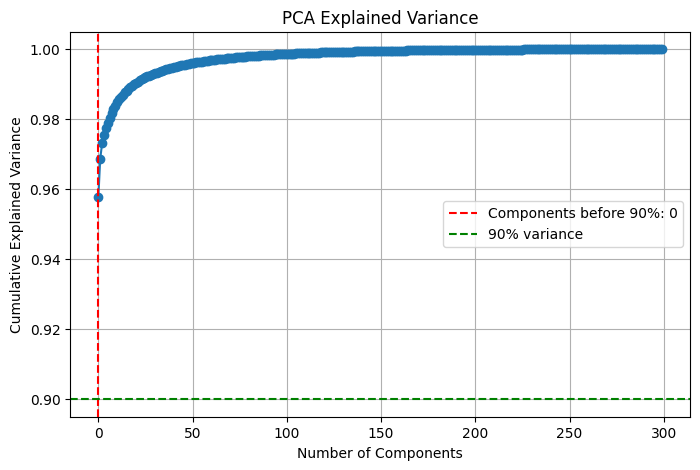

In [348]:
# Initialize PCA without specifying n_components to retain all components
# I do this instead of TruncatedSVD so I that I can more easily make this graph
pca = PCA()

# Fit PCA on the training data
pca.fit(X_train_svd)

# Calculate the cumulative variance explained by the PCA components
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components just before reaching 90% variance
components_before_cutoff = np.argmax(cumulative_variance >= 0.9)
# Print the component and variance explained around 90% variance
print(f"Number of components: {components_before_cutoff} | Variance explained: {cumulative_variance[components_before_cutoff - 1]*100:.2f}%")
print(f"Number of components: {components_before_cutoff + 1} | Variance explained: {cumulative_variance[components_before_cutoff]*100:.2f}%")

# Plot the cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axvline(x=components_before_cutoff, linestyle='--', color='r', label=f'Components before 90%: {components_before_cutoff}')
plt.axhline(y=0.9, linestyle='--', color='green', label='90% variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [376]:
# Apply PCA to the train and test set with number of components to get 90% of variance
pca_90 = PCA(n_components=components_before_cutoff + 1)

# Fit PCA on the training data
pca_90.fit(X_train_svd)

# Transform both X_train and X_test using the fitted PCA model
X_train_projected = pca_90.transform(X_train_svd)
X_test_projected = pca_90.transform(X_test_svd)

# Make sure they're dataframes
X_train_projected_df = pd.DataFrame(X_train_projected, columns=['SVD_1'])  # Will need to add more column names if SVD chooses
X_test_projected_df = pd.DataFrame(X_test_projected, columns=['SVD_1'])    # more components to pass variance threshold

In [377]:
print(X_train_projected_df.shape, X_test_projected_df.shape)

(860, 1) (215, 1)


**Scale**

In [364]:
# Instantiate scaler
scaler = StandardScaler()

# Select columns
columns = ['DATE', 'PERSON', 'ORG', 'Polarity', 'Subjectivity', 'NLTK_Compound']
X_ner_sent_train = X_train[columns]
X_ner_sent_test = X_test[columns]

In [365]:
# Fit the scaler to the training data and transform it
X_ner_sent_train_scaled = scaler.fit_transform(X_ner_sent_train)

# Transform the test data using the already-fitted scaler
X_ner_sent_test_scaled = scaler.transform(X_ner_sent_test)

In [366]:
# Make sure they're dataframes
X_ner_sent_train_scaled_df = pd.DataFrame(X_ner_sent_train_scaled, columns=columns)
X_ner_sent_test_scaled_df = pd.DataFrame(X_ner_sent_test_scaled, columns=columns)

In [383]:
X_ner_sent_test_scaled_df.head()

,DATE,PERSON,ORG,Polarity,Subjectivity,NLTK_Compound
0,-1.337909,-1.000809,-1.379637,-2.178140,0.725272,-2.683081
1,1.147498,-0.334599,0.740738,-0.505221,-0.378461,-0.356495
2,-1.337909,-0.715290,-0.319450,0.921986,-1.443204,1.260326
3,-1.053862,0.379197,-0.457735,0.026431,0.688410,-0.073127
4,-0.627792,-0.572531,-0.273355,0.396888,0.305038,0.348146


In [368]:
print(X_ner_sent_train_scaled_df.shape, X_ner_sent_test_scaled_df.shape)

(860, 6) (215, 6)


**Combine Transformed Data**

In [384]:
# Combine DataFrames
X_train_final = pd.concat([X_train_projected_df.reset_index(drop=True), X_ner_sent_train_scaled_df.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_projected_df.reset_index(drop=True), X_ner_sent_test_scaled_df.reset_index(drop=True)], axis=1)

### Evaluate Models w/ HPO

In [387]:
# SVM Hyperparameter Space
svm_param_space = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Gradient Boosting Hyperparameter Space
gb_param_space = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2']
}

In [388]:
# Optimize SVM
svm_best_model, svm_best_params, svm_performance = optimize_hyperparameters(
    model_class=SVC,
    fixed_params={},  # No fixed parameters for SVM in this case
    param_space=svm_param_space,
    X_train=X_train_final,
    y_train=y_train,
    X_test=X_test_final,
    y_test=y_test,
    optimization_strategy='grid_search',
    scoring='accuracy',
    cv=5
)

In [389]:
# Optimize Gradient Boosting
gb_best_model, gb_best_params, gb_performance = optimize_hyperparameters(
    model_class=GradientBoostingClassifier,
    fixed_params={'min_samples_leaf': 28},  # Fixed parameter of min_samples_leaf from HPO in part 1
    param_space=gb_param_space,
    X_train=X_train_final,
    y_train=y_train,
    X_test=X_test_final,
    y_test=y_test,
    optimization_strategy='grid_search',
    scoring='accuracy',
    cv=5
)

In [391]:
# Predictions with the best SVM model
svm_predictions = svm_best_model.predict(X_test_final)

# Performance metrics for SVM
print("SVM Performance:", svm_performance)
print("SVM Hyperparameters:", svm_best_params)
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

# Predictions with the best Gradient Boosting model
gb_predictions = gb_best_model.predict(X_test_final)

# Performance metrics for Gradient Boosting
print("Gradient Boosting Performance:", gb_performance)
print("Gradient Boosting Hyperparameters:", gb_best_params)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_predictions))

SVM Performance: {'accuracy': 0.8651162790697674, 'precision': 0.7872340425531915, 'recall': 0.891566265060241, 'f1-score': 0.8361581920903955}
SVM Hyperparameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       132
           1       0.79      0.89      0.84        83

    accuracy                           0.87       215
   macro avg       0.86      0.87      0.86       215
weighted avg       0.87      0.87      0.87       215

Gradient Boosting Performance: {'accuracy': 0.8604651162790697, 'precision': 0.8045977011494253, 'recall': 0.8433734939759037, 'f1-score': 0.8235294117647061}
Gradient Boosting Hyperparameters: {'learning_rate': 0.01, 'max_features': 'sqrt', 'n_estimators': 200}
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       132
           1       0.8

### Model Selection

I select the SVM model with full feature set as the best performer since it has the best performance across all three statistics in the weighted average.

### Save Models

In [392]:
%ls

Lab1/  Lab2/  Lab3/  Lab3.2/  Lab3.2_extra/  Lab3_extra/  Lab4/


In [393]:
# Save SVM model
svm_model_path = "Lab4/part4_svm_best_model.joblib"
dump(svm_best_model, svm_model_path)

# Save Gradient Boosting model
gb_model_path = "Lab4/part4_gb_best_model.joblib"
dump(gb_best_model, gb_model_path)

['Lab4/part4_gb_best_model.joblib']

## Section 5

### Table

I end up creating the table manually here because it's faster than rerunning everything and worrying about variable namings.

In [ ]:
"""
# Part 1
SVM Performance: {'accuracy': 0.8697674418604651, 'precision': 0.8089887640449438, 'recall': 0.8674698795180723, 'f1-score': 0.8372093023255814}
Gradient Boosting Performance: {'accuracy': 0.8465116279069768, 'precision': 0.7840909090909091, 'recall': 0.8313253012048193, 'f1-score': 0.8070175438596491}

# Part 2
SVM Original Performance: {'accuracy': 0.6139534883720931, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}
Gradient Boosting Original Performance: {'accuracy': 0.8697674418604651, 'precision': 0.8481012658227848, 'recall': 0.8072289156626506, 'f1-score': 0.8271604938271606}
SVM Reduced Best Hyperparameters: {'accuracy': 0.6139534883720931, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}
Gradient Boosting Reduced Best Hyperparameters: {'accuracy': 0.6186046511627907, 'precision': 1.0, 'recall': 0.012048192771084338, 'f1-score': 0.02380952380952381}

# Part 3
SVM Performance: {'accuracy': 0.8651162790697674, 'precision': 0.7872340425531915, 'recall': 0.891566265060241, 'f1-score': 0.8361581920903955}
Gradient Boosting Performance: {'accuracy': 0.8558139534883721, 'precision': 0.7888888888888889, 'recall': 0.8554216867469879, 'f1-score': 0.8208092485549133}

# Part 4
SVM Performance: {'accuracy': 0.8651162790697674, 'precision': 0.7872340425531915, 'recall': 0.891566265060241, 'f1-score': 0.8361581920903955}
Gradient Boosting Performance: {'accuracy': 0.8604651162790697, 'precision': 0.8045977011494253, 'recall': 0.8433734939759037, 'f1-score': 0.8235294117647061}
"""

In [398]:
# Example specific values
parts = ["Part 1", "Part 1", "Part 2", "Part 2", "Part 2", "Part 2", "Part 3", "Part 3", "Part 4", "Part 4"]
model_types = ["SVM", "Gradient Boosting", "SVM", "Gradient Boosting", "SVM", "Gradient Boosting", "SVM", "Gradient Boosting", "SVM", "Gradient Boosting"]
feature_types = ["Full", "Full", "Full", "Full", "SVD", "SVD", "Full", "Full", "SVD", "SVD"]

# Example dictionary for the metrics
metrics = [
    {'accuracy': 0.8697674418604651, 'precision': 0.8089887640449438, 'recall': 0.8674698795180723, 'f1-score': 0.8372093023255814},
    {'accuracy': 0.8465116279069768, 'precision': 0.7840909090909091, 'recall': 0.8313253012048193, 'f1-score': 0.8070175438596491},
    {'accuracy': 0.6139534883720931, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0},
    {'accuracy': 0.8697674418604651, 'precision': 0.8481012658227848, 'recall': 0.8072289156626506, 'f1-score': 0.8271604938271606},
    {'accuracy': 0.6139534883720931, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0},
    {'accuracy': 0.6186046511627907, 'precision': 1.0, 'recall': 0.012048192771084338, 'f1-score': 0.02380952380952381},
    {'accuracy': 0.8651162790697674, 'precision': 0.7872340425531915, 'recall': 0.891566265060241, 'f1-score': 0.8361581920903955},
    {'accuracy': 0.8558139534883721, 'precision': 0.7888888888888889, 'recall': 0.8554216867469879, 'f1-score': 0.8208092485549133},
    {'accuracy': 0.8651162790697674, 'precision': 0.7872340425531915, 'recall': 0.891566265060241, 'f1-score': 0.8361581920903955},
    {'accuracy': 0.8604651162790697, 'precision': 0.8045977011494253, 'recall': 0.8433734939759037, 'f1-score': 0.8235294117647061}
]

# Creating the DataFrame
df_data = {
    "Part": parts,
    "Model Type": model_types,
    "Feature Type": feature_types,
    "Accuracy": [metric["accuracy"] for metric in metrics],
    "Precision": [metric["precision"] for metric in metrics],
    "Recall": [metric["recall"] for metric in metrics],
    "F1-Score": [metric["f1-score"] for metric in metrics]
}

performance_df = pd.DataFrame(df_data)

In [399]:
performance_df.head(10)

,Part,Model Type,Feature Type,Accuracy,Precision,Recall,F1-Score
0,Part 1,SVM,Full,0.869767,0.808989,0.867470,0.837209
1,Part 1,Gradient Boosting,Full,0.846512,0.784091,0.831325,0.807018
2,Part 2,SVM,Full,0.613953,0.000000,0.000000,0.000000
3,Part 2,Gradient Boosting,Full,0.869767,0.848101,0.807229,0.827160
4,Part 2,SVM,SVD,0.613953,0.000000,0.000000,0.000000
5,Part 2,Gradient Boosting,SVD,0.618605,1.000000,0.012048,0.023810
6,Part 3,SVM,Full,0.865116,0.787234,0.891566,0.836158
7,Part 3,Gradient Boosting,Full,0.855814,0.788889,0.855422,0.820809
8,Part 4,SVM,SVD,0.865116,0.787234,0.891566,0.836158
9,Part 4,Gradient Boosting,SVD,0.860465,0.804598,0.843373,0.823529


### Model Selection

Based on the provided performance metrics for each part, model type, and feature set, I select the Gradient Boosting classifier using the full feature set in Part 2 (row 3 in dataframe).

This model exhibits the highest overall performance in terms of accuracy (0.869767), precision (0.848101), and a very competitive f1-score (0.827160). This suggests that Gradient Boosting effectively leverages the full set of features to make accurate predictions, balancing both precision and recall effectively, as indicated by its f1-score.

This model was fed doc2vec features, which is in line with the expectation that deep learning embeddings more thoroughly represent language that knowledge-based methods like BOW or NER. Lastly, with the 90% variance cutoff for PCA/SVD, we only had 1 feature, which explains the poor performance in those models.